In [161]:
# !pip install box2d-py
# !pip install gym[Box_2D]

In [162]:
# import urllib.request
# urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
# !pip install unrar
# !unrar x Roms.rar
# !mkdir rars
# !mv HC\ ROMS.zip   rars
# !mv ROMS.zip  rars
# !python -m atari_py.import_roms rars

In [163]:
import gym
import math
import random
import numpy as np
from collections import deque
from tqdm import trange
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

import torchvision.transforms as T

In [164]:
import warnings
warnings.filterwarnings("ignore")

# 1. As from lab 4, we did the bipedalwalker for Q-learning, please change it to be DQN.

In [165]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [166]:
def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [167]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [168]:
class DQN(nn.Module):
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0)).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else:
            action = random.randrange(env.action_space.shape[0])
        return action

In [169]:
env = gym.make('BipedalWalker-v3')
env.reset()
model = DQN(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(1000)

In [170]:
def compute_td_loss(model, batch_size, gamma=0.99):
    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    with torch.no_grad():
        next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state))).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [171]:
def plot(episode, rewards, losses):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

In [172]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # Take a step
        convert_action = [-1, -1, -1, -1]
        convert_action[action] = 1
        next_state, reward, done, _ = env.step(convert_action)

        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

Agent training (episode10001) Avg Reward -0.38965903760719883: 100%|██████████| 10001/10001 [02:10<00:00, 76.73it/s]


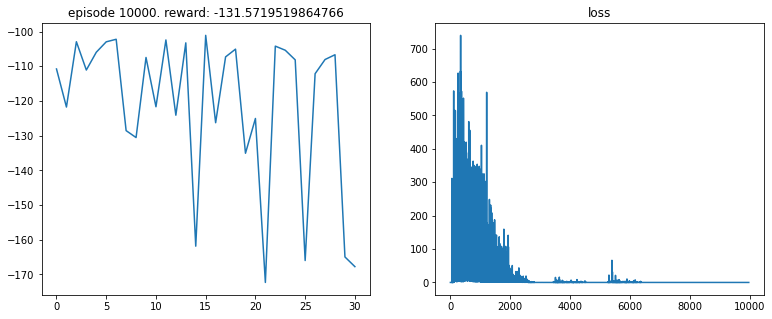

In [173]:
model, all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes=10000, batch_size=32, gamma=0.90)

# 2. In spaceInvader, use DQN in CNN, try to change state in put to 3 or 5 frames for DQN input in difference timing.

In [174]:
image_size = 84

transform = T.Compose([T.ToPILImage(),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

# Convert to RGB image (3 channels)

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state2 = torch.zeros(9, 84, 84)
    state2[0:3] = transform(state[0:3])
    state2[3:6] = transform(state[3:6])
    state2[6:9] = transform(state[6:9])
    return state2

# Train the DQN CNN

def train_CNNDQN(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    # change from get_state to get_state2
    obs3state = np.zeros([210, 160, 3*3])
    obs3state[:, :, 0:3] = obs
    obs3state[:, :, 3:6] = obs
    obs3state[:, :, 6:9] = obs
    state = get_state2(obs3state)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        # change from get_state to get_state2
        obs3state[:, :, 0:6] = obs3state[:, :, 3:9]
        obs3state[:, :, 6:9] = next_obs
        next_state = get_state2(obs3state)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            # change from get_state to get_state2
            obs3state[:, :, 0:3] = obs
            obs3state[:, :, 3:6] = obs
            obs3state[:, :, 6:9] = obs
            state = get_state2(obs3state)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model, all_rewards, losses

In [175]:
class CNNDQN(nn.Module):
    def __init__(self, n_channel, n_action):
        super(CNNDQN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=n_channel, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.fc1= nn.Linear(7*7*64, 512)
        self.fc2= nn.Linear(512, n_action)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def act(self, state, epsilon):
        # get action from policy action and epsilon greedy
        if random.random() > epsilon: # get action from old q-values
            with torch.no_grad():
                state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0)).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action  = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

Agent training (episode50001) Avg Reward 0.1366972660546789: 100%|██████████| 50001/50001 [31:18<00:00, 26.61it/s]


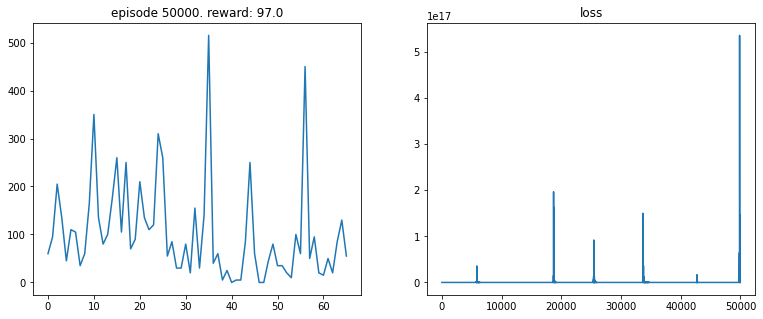

In [176]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

# print(env.unwrapped.get_action_meanings())
# print(env.observation_space.shape)

model = CNNDQN(3*3, env.action_space.n).to(device)

optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model, all_rewards, losses = train_CNNDQN(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)